# The Copernicus Climate Change Service
The Copernicus Climate Change Service ([C3S](https://climate.copernicus.eu/)) provides information about climate change through  historical data sets (reanalysis) and projections of essential climate variables such as winds, precipitation, temperature, pressure, greenhouse gases. C3S is operated by the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int/)) on behalf of the European Commission.

The purpose of this notebook is to

1. Test the C3S web service API
2. Plot the hourly temperatures at the grid points on a map over Italy from Septemper 2020 to October 2020
3. As an exercise, we compute the mean temperatures in Rome in September 2020 and then we plot the result as time series.  

## The ERA5 Reanalysis dataset
ERA5 reanalysis is a dataset that combines a vast amount of observations of climate variables from the near real time back in time till, so far, 1979. The aim of the project is to assimilate historical observations back to 1950. The dataset contains estimations of many climate variables on a grid whose horizontal resolution, the distance between any two points of the grid, is 0.5°x0.5° or 55 km for atmospheric data. The ERA5 estimations are computed by integrating the values obtained using the ECMWF climate model with the historical observations from in-situ and satellite data. 

### Data assimilation
The technique used to integrate the model data with the observations is called assimilation. At any given hour the the data computed by the model are compared with the observations at any grid point. Since both observations and model data have errors a cost function is used to compute the distance between the two values, weighted by their errors. The result is a better estimation of the climate variable at that time and grid point. The estimations represent an analysis that is used as new input for the model to compute the next time slot that will be again compared with the observations available at that time to produce the corresponding analysis.          

## The ERA5 hourly 2m-temperature
We select the [C3S ERA5 hourly data on single levels from 1979 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels) data set to retrieve the temperature data over the Italian region between September and October 14th 2020 that, at the time of our request (18th October 2020), represents the near real time. The 2m temperature is the temperature of the air at 2m above the surface, land and sea. Since we want to limit the size of the data we choose a frequency of 3 hours. The format of the data is [NetCDF4](https://www.unidata.ucar.edu/software/netcdf/docs/netcdf_introduction.html). According to our selection the data will contain a cube of 44 days and 44x8 = 352 tables of temperature values, one each point in the grid. The selected area is between 47.12 degrees latitude North, 36.4 latitude South and 6.57 degrees longitude West and 18.52 longitude East. The selected area contains 43x48 = 2064 points so each table, or slice, contains 2064 temperature values (in Kelvin).

## The ERA5 hourly data web service
In order to use the API, you have to be registered into the CDS and

1. login 
2. copy your CDS API key in the .condarc file in your home folder 
3. install the cdsapi Python package

For more information follow the [how-to instructions](https://cds.climate.copernicus.eu/api-how-to). Pay attention to not confuse the CDS API key with the ADS API key that is used to access the Atmosphere Monitoring Service.

We import all the Python packages that will be used to retrieve the data. We will import additional packages later on for plotting the temperatures.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cdsapi
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)

python version: 3.8.2
pandas version: 1.0.2
xarray version: 0.14.0


In [3]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '2m_temperature'
        ],
        'year': '2020',
        'month': [
            '09', '10',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': [
            47.12, 6.57, 36.4,
            18.52,
        ],
        'format': 'netcdf',
    },
    '2m_temperature.nc')

2020-10-18 20:33:06,249 INFO Welcome to the CDS
2020-10-18 20:33:06,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-10-18 20:33:06,549 INFO Request is queued
2020-10-18 20:33:07,589 INFO Request is running
2020-10-18 20:33:27,551 INFO Request is completed
2020-10-18 20:33:27,553 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data3/adaptor.mars.internal-1603045986.1201465-16130-19-039d64c9-4608-4859-ae18-4c8e15bb6c60.nc to download.nc (1.4M)
2020-10-18 20:33:28,041 INFO Download rate 2.8M/s   


Result(content_length=1455892,content_type=application/x-netcdf,location=http://136.156.133.39/cache-compute-0012/cache/data3/adaptor.mars.internal-1603045986.1201465-16130-19-039d64c9-4608-4859-ae18-4c8e15bb6c60.nc)

We read the data and visualize some information about the content.

In [2]:
era5_xr = xr.open_dataset('2m_temperature.nc')
era5_xr

<xarray.Dataset>
Dimensions:    (latitude: 43, longitude: 48, time: 352)
Coordinates:
  * longitude  (longitude) float32 6.57 6.82 7.07 7.32 ... 17.82 18.07 18.32
  * latitude   (latitude) float32 46.9 46.65 46.4 46.15 ... 36.9 36.65 36.4
  * time       (time) datetime64[ns] 2020-09-01 ... 2020-10-14T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-18 18:33:21 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

As we can see from the dimensions, the data contains 352 time slices of 43x48 = 2064 grid points.

In [3]:
lats = era5_xr['latitude']
print("Latitude West: {0:.2f}, Latitude East: {1:.2f}".format(lats.data.min(), lats.data.max()))

Latitude West: 36.40, Latitude East: 46.90


In [4]:
lons = era5_xr['longitude']
print("Longitude South: {0:.2f}, Longitude North: {1:.2f}".format(lons.data.min(), lons.data.max()))

Longitude South: 6.57, Longitude North: 18.32


Now we put the full temperature data in memory and then we close the file since we won't need it anymore.

In [5]:
temperature2m = era5_xr['t2m']
temperature2m

<xarray.DataArray 't2m' (time: 352, latitude: 43, longitude: 48)>
[726528 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 6.57 6.82 7.07 7.32 ... 17.82 18.07 18.32
  * latitude   (latitude) float32 46.9 46.65 46.4 46.15 ... 36.9 36.65 36.4
  * time       (time) datetime64[ns] 2020-09-01 ... 2020-10-14T21:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [6]:
era5_xr.close()

## Plotting the temperature data
We want to plot on a map one time slice of the temperature values, so we import the Python libraries.

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
print("matplotlib version: %s"%matplotlib.__version__)
print("cartopy version: %s"%cartopy.__version__)

matplotlib version: 3.3.1
cartopy version: 0.18.0


We plot the data on a map using the [plate carre projection](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#platecarree), a particular case of the [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection). We plot the costline and also rivers and lakes just to show that they are available. We plot only one (time) slice of the 352 available.

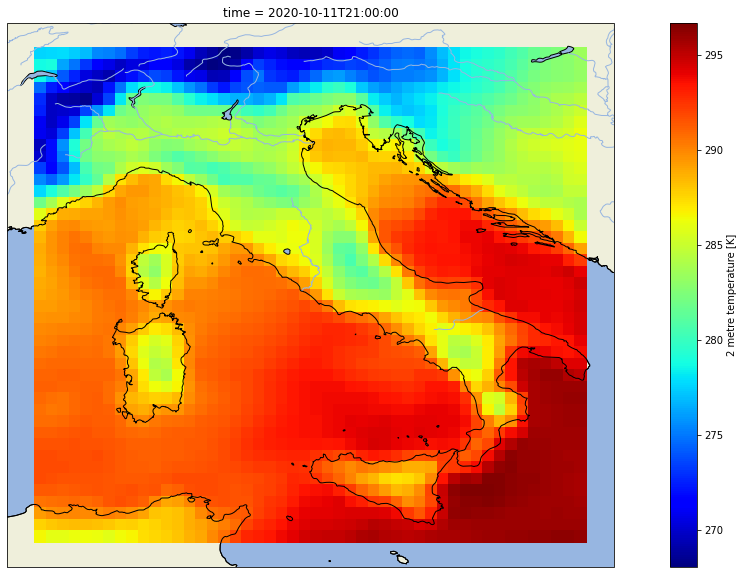

In [8]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.coastlines()
temperature2m[327].plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet')

We color of each cell, centered on one of the grid points, represents the temperature value.

We plot the data using the orthographic projection on the entire globe as well, even if our data cover only the Italian region. In order to plot 

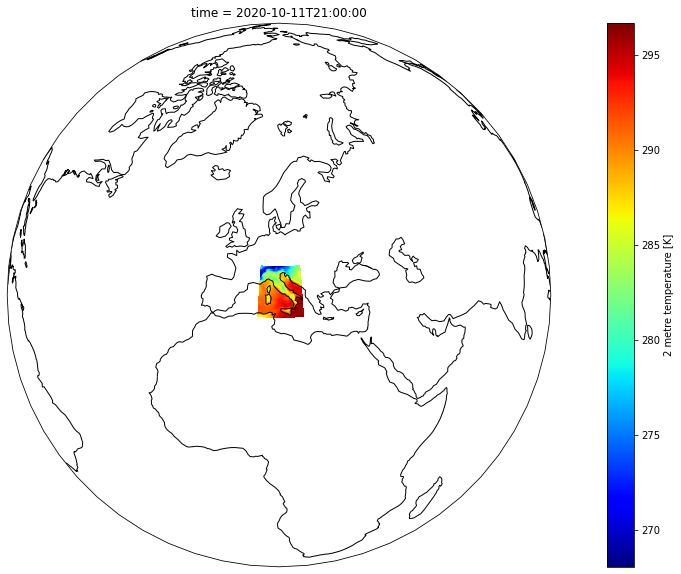

In [9]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=12, central_latitude=41))
ax.coastlines()
ax.set_global()
temperature2m[327].plot.pcolormesh(ax=ax, 
                                   x='longitude', 
                                   y='latitude', 
                                   add_colorbar=True, 
                                   cmap='jet', 
                                   transform=ccrs.PlateCarree())

## Compute the mean temperatures in Rome in September 2020
write something about downscaling

## References
- [Hersbach et al. - The ERA5 global reanalysis](https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/qj.3803)
- [Talagrand - Assimilation of Information, an Introduction](https://indico.fysik.su.se/event/2654/attachments/1559/1707/Talagrand.1987.pdf)
- [Law et al. - Data Assimilation: A Mathematical Introduction](https://arxiv.org/abs/1506.07825)
- [Carrassi et al. - Data Assimilation in the Geosciences](https://arxiv.org/abs/1709.02798)